# SARIMA Baseline Models for Pan-Arctic Sea Ice Extent

This notebook implements two SARIMA (Seasonal AutoRegressive Integrated Moving Average) models:
1. **Model 1:** SARIMA on raw monthly ice extent values
2. **Model 2:** SARIMA on monthly anomaly values (deviation from climatology)

We use monthly aggregation (seasonal period s=12) to make SARIMA computationally tractable while preserving seasonal patterns. Daily data with s=365 would be prohibitively slow.

In [6]:
from src.data_utils import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

## Data Loading & Preparation

Load daily pan-arctic ice extent data and aggregate to monthly means. Monthly aggregation:
- Reduces ~16,000 daily observations to ~540 monthly observations
- Smooths day-to-day weather noise while preserving seasonal patterns
- Makes SARIMA with seasonal period s=12 computationally feasible

In [7]:
daily_data = load_data(regions='pan_arctic', years='all')

print(f"Loaded {len(daily_data)} daily observations")
print(f"Date range: {daily_data['date'].min()} to {daily_data['date'].max()}")
print(f"\nFirst few rows:")
print(daily_data[['date', 'extent_mkm2']].head())

Loaded 16436 daily observations
Date range: 1979-01-01 00:00:00 to 2023-12-31 00:00:00

First few rows:
        date  extent_mkm2
0 1979-01-01          NaN
1 1979-01-02       14.997
2 1979-01-03          NaN
3 1979-01-04       14.922
4 1979-01-05          NaN


### Monthly Aggregation

Calculate mean ice extent for each month across the entire time series.

In [8]:
monthly_data = daily_data.groupby(daily_data['date'].dt.to_period('M')).agg({
    'extent_mkm2': 'mean',
    'date': 'first'
}).reset_index(drop=True)

monthly_data['date'] = monthly_data['date'].dt.to_period('M')
monthly_data = monthly_data.set_index('date')

print(f"Aggregated to {len(monthly_data)} monthly observations")
print(f"\nMonthly data sample:")
print(monthly_data.head(12))

Aggregated to 540 monthly observations

Monthly data sample:
         extent_mkm2
date                
1979-01    15.414000
1979-02    16.175286
1979-03    16.341938
1979-04    15.446800
1979-05    13.856867
1979-06    12.530000
1979-07    10.311250
1979-08     8.041067
1979-09     7.051133
1979-10     8.747937
1979-11    10.943067
1979-12    13.336267


## Exploratory Analysis

Visualize the monthly time series to understand:
- Long-term trends (declining ice extent)
- Seasonal patterns (maximum in March, minimum in September)
- Variability across years

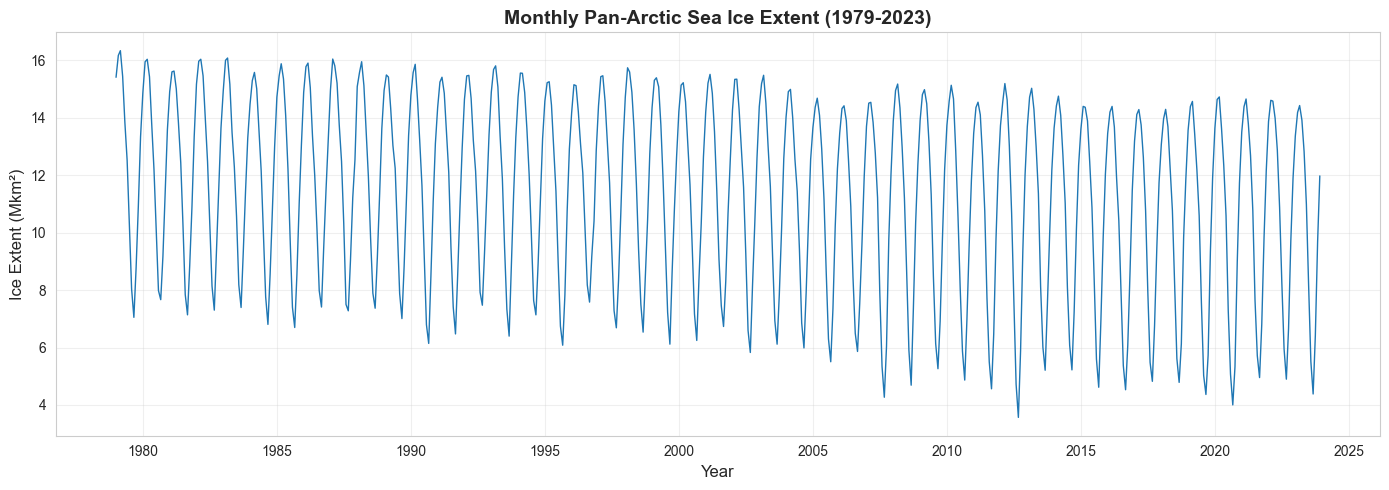

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(monthly_data.index.to_timestamp(), monthly_data['extent_mkm2'], linewidth=1)
ax.set_title('Monthly Pan-Arctic Sea Ice Extent (1979-2023)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Ice Extent (Mkm²)', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Seasonal Pattern Visualization

Box plots show the distribution of ice extent for each month, revealing the strong annual cycle characteristic of Arctic sea ice.

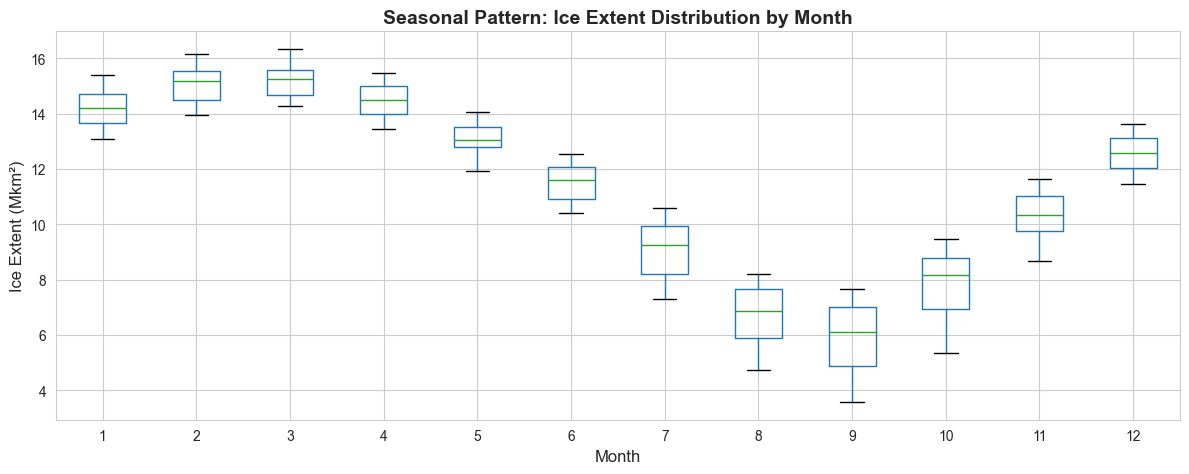

In [10]:
monthly_data_with_month = monthly_data.copy()
monthly_data_with_month['month'] = monthly_data_with_month.index.month

fig, ax = plt.subplots(figsize=(12, 5))

monthly_data_with_month.boxplot(column='extent_mkm2', by='month', ax=ax)
ax.set_title('Seasonal Pattern: Ice Extent Distribution by Month', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Ice Extent (Mkm²)', fontsize=12)

plt.suptitle('')
plt.tight_layout()
plt.show()

## Climatology & Anomaly Calculation

**Climatology:** The long-term average ice extent for each month (e.g., average across all Januaries)

**Anomaly:** Deviation from climatology = Actual value - Climatology baseline

Anomalies remove the strong seasonal component, which can:
- Make the time series more stationary
- Allow SARIMA to focus on interannual variability rather than predictable seasonal cycles
- Potentially improve model performance

In [11]:
monthly_data_for_climatology = monthly_data.copy()
monthly_data_for_climatology['month'] = monthly_data_for_climatology.index.month

monthly_climatology = monthly_data_for_climatology.groupby('month')['extent_mkm2'].mean()

print("Monthly Climatology (Mean Ice Extent by Month):")
print(monthly_climatology.to_frame().rename(columns={'extent_mkm2': 'Mean Extent (Mkm²)'}))

Monthly Climatology (Mean Ice Extent by Month):
       Mean Extent (Mkm²)
month                    
1               14.208441
2               15.069672
3               15.224043
4               14.498535
5               13.106315
6               11.513634
7                9.059266
8                6.742571
9                5.933388
10               7.829231
11              10.399089
12              12.606130


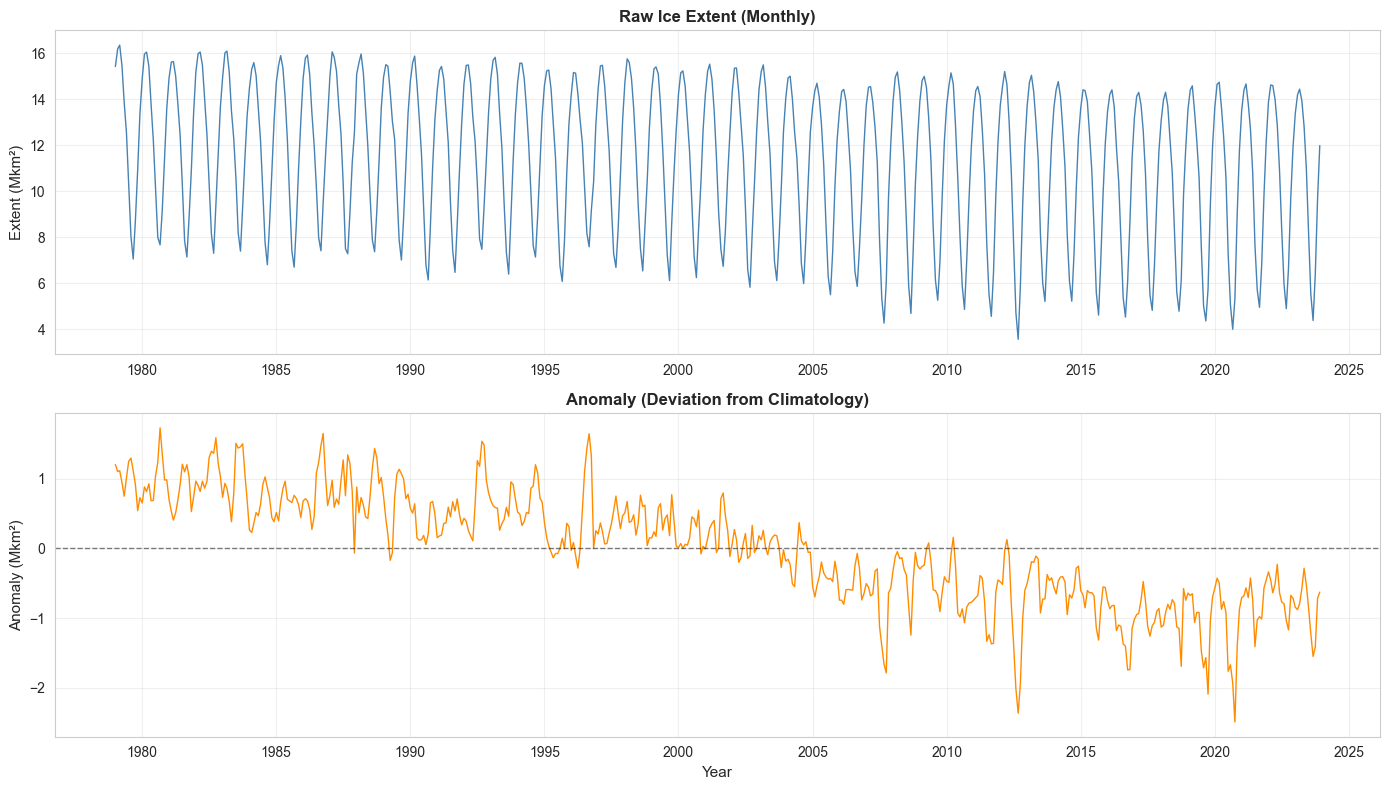

In [12]:
monthly_data_for_climatology['anomaly_mkm2'] = (
    monthly_data_for_climatology['extent_mkm2'] - 
    monthly_data_for_climatology['month'].map(monthly_climatology)
)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(monthly_data_for_climatology.index.to_timestamp(), 
             monthly_data_for_climatology['extent_mkm2'], 
             color='steelblue', linewidth=1)
axes[0].set_title('Raw Ice Extent (Monthly)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Extent (Mkm²)', fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(monthly_data_for_climatology.index.to_timestamp(), 
             monthly_data_for_climatology['anomaly_mkm2'], 
             color='darkorange', linewidth=1)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)
axes[1].set_title('Anomaly (Deviation from Climatology)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Anomaly (Mkm²)', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Train/Test Split

**Critical for time series:** Must preserve temporal order.

- **Training set:** 1979-2018 (40 years = 480 months)
- **Test set:** 2019-2023 (5 years = 60 months)

We train on the past and evaluate on the future, simulating real-world forecasting scenarios.

In [13]:
train_test_split_date = '2019-01'

train_data = monthly_data_for_climatology[monthly_data_for_climatology.index < train_test_split_date].copy()
test_data = monthly_data_for_climatology[monthly_data_for_climatology.index >= train_test_split_date].copy()

print(f"Training set: {len(train_data)} months ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Test set: {len(test_data)} months ({test_data.index[0]} to {test_data.index[-1]})")

train_extent_raw = train_data['extent_mkm2']
test_extent_raw = test_data['extent_mkm2']
train_extent_anomaly = train_data['anomaly_mkm2']
test_extent_anomaly = test_data['anomaly_mkm2']

Training set: 480 months (1979-01 to 2018-12)
Test set: 60 months (2019-01 to 2023-12)


## Stationarity Testing

**Stationarity** is a key assumption for ARIMA models. A stationary time series has:
- Constant mean over time
- Constant variance over time
- No seasonal patterns

**Augmented Dickey-Fuller (ADF) Test:**
- Null hypothesis: Series is non-stationary
- p-value < 0.05: Reject null → Series is stationary
- p-value ≥ 0.05: Fail to reject → Series is non-stationary (need differencing)

We expect:
- Raw extent: Non-stationary (strong trend and seasonality) → Need differencing (d>0, D>0)
- Anomalies: More stationary (seasonality removed) → May need less differencing

In [14]:
def run_adf_test_and_print(time_series, series_name):
    adf_result = adfuller(time_series.dropna())
    
    print(f'\n{series_name}:')
    print(f'  ADF Statistic: {adf_result[0]:.4f}')
    print(f'  p-value: {adf_result[1]:.4f}')
    print(f'  Critical Values:')
    for key, value in adf_result[4].items():
        print(f'    {key}: {value:.4f}')
    
    is_stationary = adf_result[1] < 0.05
    print(f'  Result: {"STATIONARY" if is_stationary else "NON-STATIONARY (need differencing)"}')

print("="*70)
print("AUGMENTED DICKEY-FULLER STATIONARITY TESTS")
print("="*70)

run_adf_test_and_print(train_extent_raw, 'Raw Ice Extent (Training Set)')
run_adf_test_and_print(train_extent_anomaly, 'Anomaly Values (Training Set)')

print("="*70)

AUGMENTED DICKEY-FULLER STATIONARITY TESTS

Raw Ice Extent (Training Set):
  ADF Statistic: -0.9717
  p-value: 0.7634
  Critical Values:
    1%: -3.4444
    5%: -2.8677
    10%: -2.5701
  Result: NON-STATIONARY (need differencing)

Anomaly Values (Training Set):
  ADF Statistic: -0.9863
  p-value: 0.7582
  Critical Values:
    1%: -3.4444
    5%: -2.8677
    10%: -2.5701
  Result: NON-STATIONARY (need differencing)


### Autocorrelation Analysis

**ACF (Autocorrelation Function):** Correlation between series and its lagged values
- Helps identify MA (Moving Average) order q
- Slow decay suggests non-stationarity or seasonal patterns

**PACF (Partial Autocorrelation Function):** Direct correlation at each lag, controlling for shorter lags
- Helps identify AR (AutoRegressive) order p

Strong peaks at lag 12, 24, 36 indicate annual seasonality (12-month cycle).

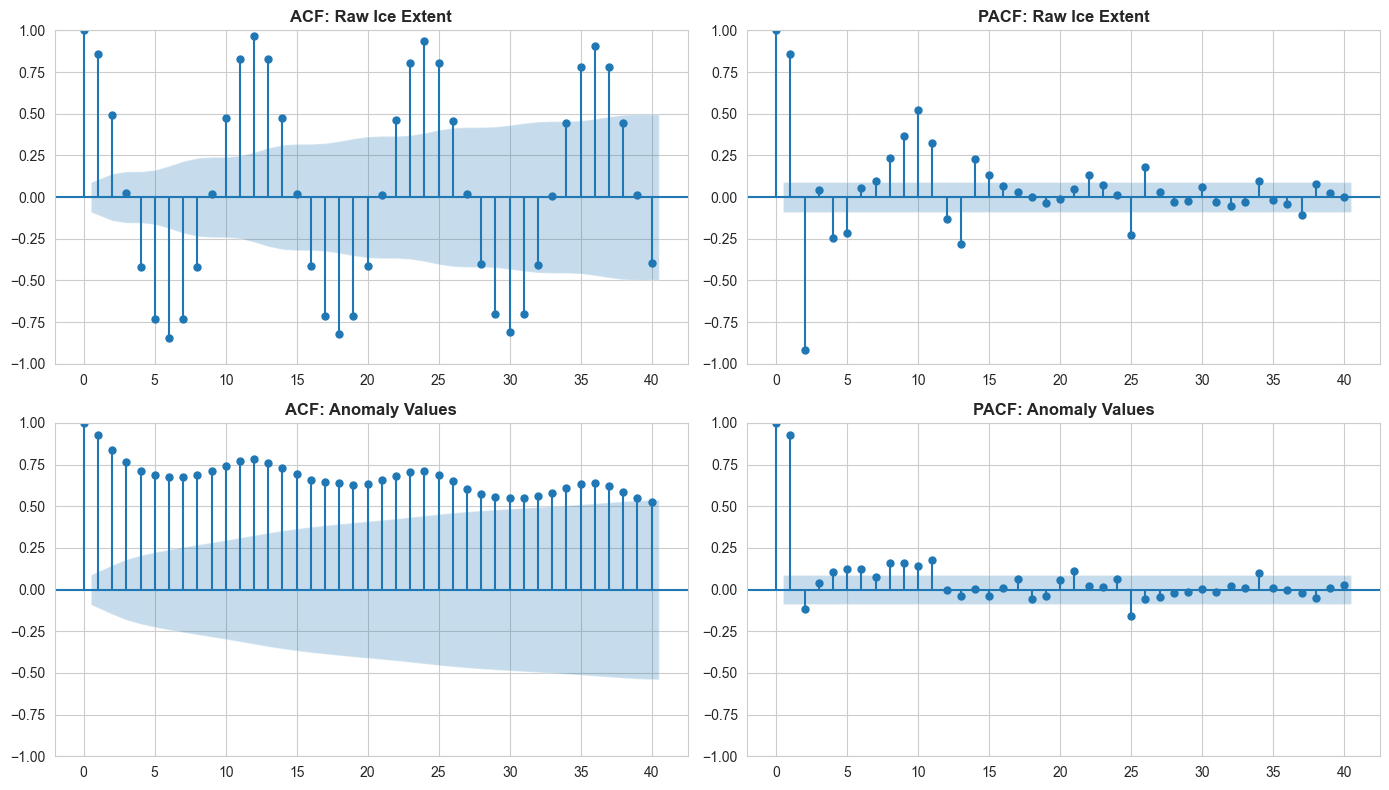

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

plot_acf(train_extent_raw.dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF: Raw Ice Extent', fontweight='bold')

plot_pacf(train_extent_raw.dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF: Raw Ice Extent', fontweight='bold')

plot_acf(train_extent_anomaly.dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF: Anomaly Values', fontweight='bold')

plot_pacf(train_extent_anomaly.dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF: Anomaly Values', fontweight='bold')

plt.tight_layout()
plt.show()

## Model 1: SARIMA on Raw Ice Extent Values

**SARIMA Notation:** SARIMA(p,d,q)(P,D,Q,s)

**Non-seasonal components:**
- p: AutoRegressive order
- d: Differencing order
- q: Moving Average order

**Seasonal components:**
- P: Seasonal AR order
- D: Seasonal differencing order
- Q: Seasonal MA order
- s: Seasonal period (12 for monthly data)

**Starting parameters:** SARIMA(1,1,1)(1,1,1,12)
- d=1: First-order differencing for trend
- D=1: Seasonal differencing for annual cycle
- p=q=P=Q=1: Simple orders based on ACF/PACF

In [16]:
sarima_order_raw = (1, 0, 1)
sarima_seasonal_order_raw = (0, 1, 1, 12)

print(f"Fitting SARIMA{sarima_order_raw}x{sarima_seasonal_order_raw} on raw ice extent...")
print("This may take 1-2 minutes...\n")

sarima_model_raw = SARIMAX(
    train_extent_raw, 
    order=sarima_order_raw, 
    seasonal_order=sarima_seasonal_order_raw,
)

sarima_results_raw = sarima_model_raw.fit(disp=False)

print(sarima_results_raw.summary())

Fitting SARIMA(1, 0, 1)x(0, 1, 1, 12) on raw ice extent...
This may take 1-2 minutes...

                                     SARIMAX Results                                      
Dep. Variable:                        extent_mkm2   No. Observations:                  480
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -26.129
Date:                            Sat, 11 Oct 2025   AIC                             60.258
Time:                                    14:46:45   BIC                             76.852
Sample:                                01-31-1979   HQIC                            66.788
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7109    

### Generate Forecasts on Test Set

Forecast 60 months ahead (2019-2023) and compute 95% confidence intervals.

In [17]:
num_forecast_steps = len(test_data)

forecast_raw_values = sarima_results_raw.forecast(steps=num_forecast_steps)
forecast_raw_series = pd.Series(forecast_raw_values, index=test_data.index)

forecast_raw_object = sarima_results_raw.get_forecast(steps=num_forecast_steps)
forecast_raw_confidence_intervals = forecast_raw_object.conf_int()

### Evaluate Model 1 Performance

Calculate error metrics on the test set:
- **RMSE:** Root Mean Squared Error (penalizes large errors)
- **MAE:** Mean Absolute Error (average magnitude of errors)
- **MAPE:** Mean Absolute Percentage Error (scale-independent)

In [18]:
rmse_model1 = np.sqrt(mean_squared_error(test_extent_raw, forecast_raw_series))
mae_model1 = mean_absolute_error(test_extent_raw, forecast_raw_series)
mape_model1 = np.mean(np.abs((test_extent_raw - forecast_raw_series) / test_extent_raw)) * 100

print("="*70)
print("MODEL 1: SARIMA ON RAW VALUES")
print("="*70)
print(f"  RMSE: {rmse_model1:.4f} Mkm²")
print(f"  MAE:  {mae_model1:.4f} Mkm²")
print(f"  MAPE: {mape_model1:.2f}%")
print("="*70)

MODEL 1: SARIMA ON RAW VALUES
  RMSE: 0.3572 Mkm²
  MAE:  0.2668 Mkm²
  MAPE: 3.53%


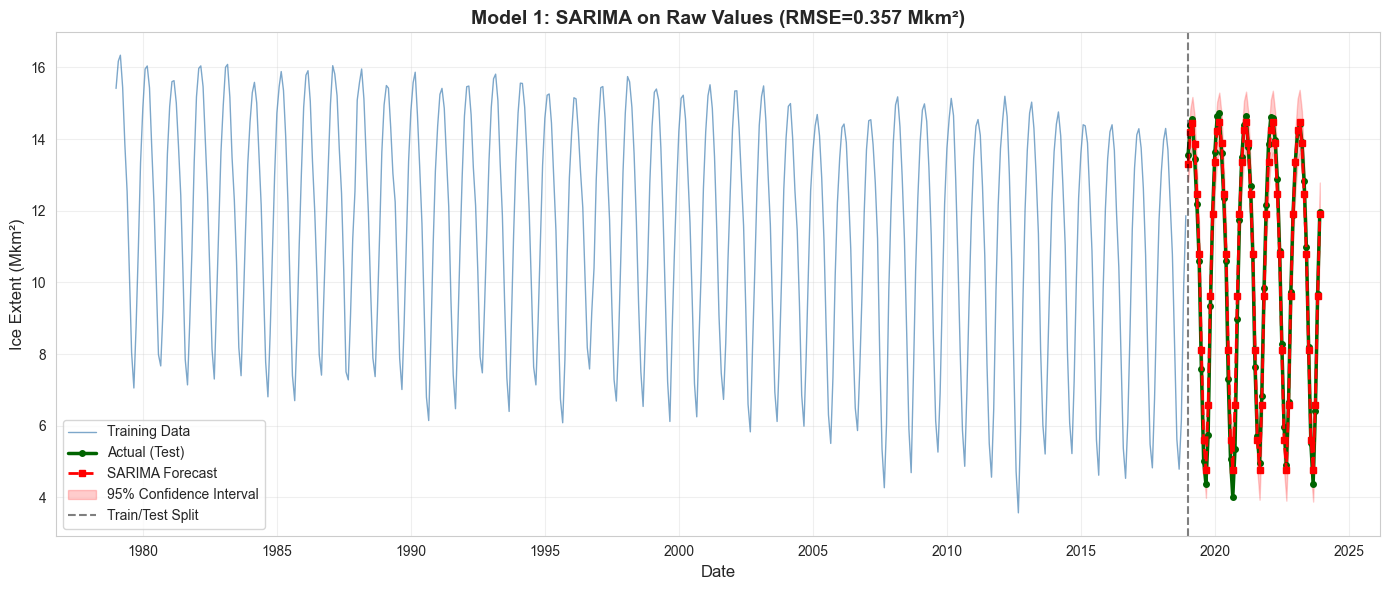

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index.to_timestamp(), train_extent_raw, 
        label='Training Data', color='steelblue', alpha=0.7, linewidth=1)

ax.plot(test_data.index.to_timestamp(), test_extent_raw, 
        label='Actual (Test)', color='darkgreen', linewidth=2.5, marker='o', markersize=4)

ax.plot(test_data.index.to_timestamp(), forecast_raw_series, 
        label='SARIMA Forecast', color='red', linewidth=2, linestyle='--', marker='s', markersize=4)

ax.fill_between(
    test_data.index.to_timestamp(), 
    forecast_raw_confidence_intervals.iloc[:, 0], 
    forecast_raw_confidence_intervals.iloc[:, 1], 
    alpha=0.2, color='red', label='95% Confidence Interval'
)

ax.axvline(pd.Period(train_test_split_date).to_timestamp(), 
           color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Train/Test Split')

ax.set_title(f'Model 1: SARIMA on Raw Values (RMSE={rmse_model1:.3f} Mkm²)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ice Extent (Mkm²)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Residual Diagnostics

Good SARIMA models should have residuals that are:
1. **Normally distributed** (QQ plot should be linear)
2. **No autocorrelation** (ACF should show no significant spikes)
3. **Constant variance** (homoscedastic)
4. **Mean zero** (centered around zero)

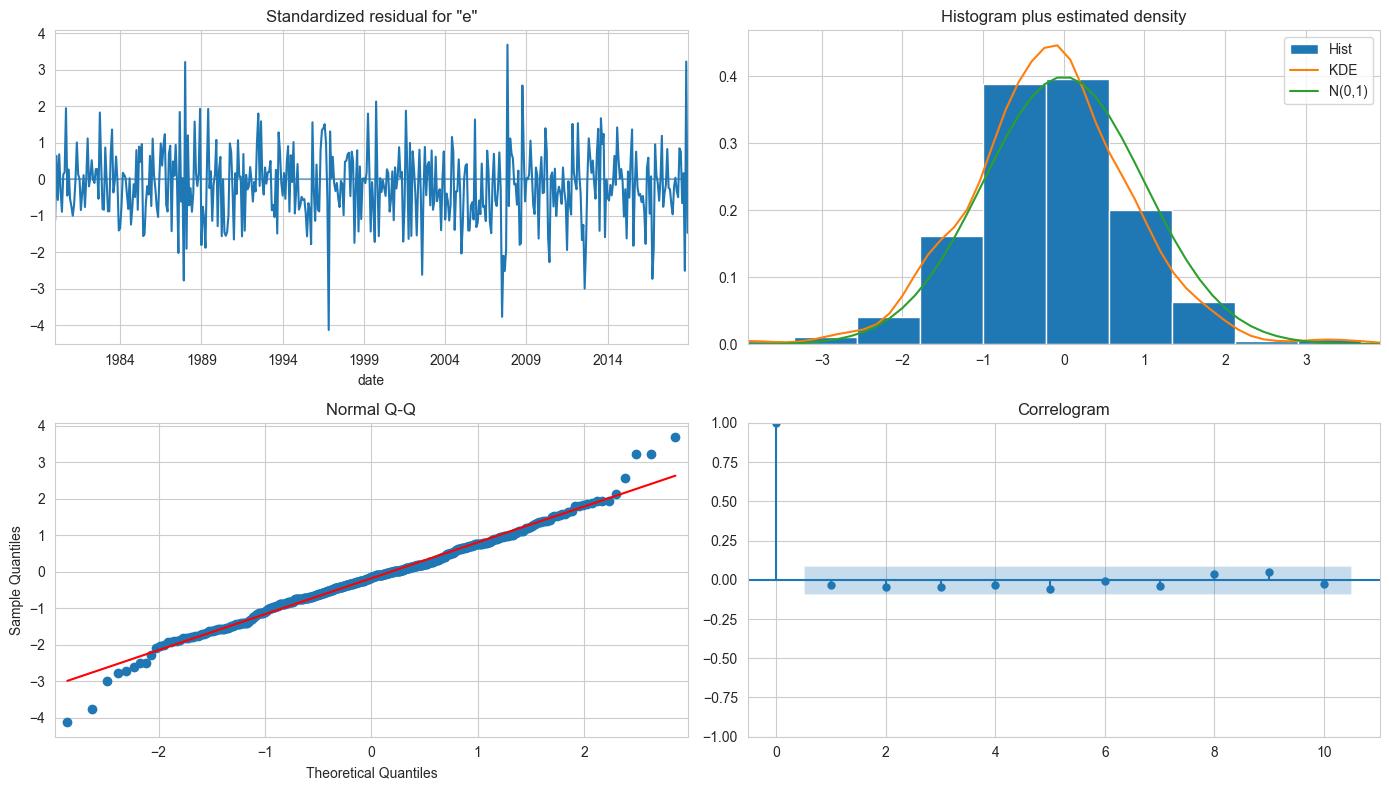

In [20]:
sarima_results_raw.plot_diagnostics(figsize=(14, 8))
plt.tight_layout()
plt.show()

## Model 2: SARIMA on Anomaly Values

**Strategy:** Model anomalies (deviations from climatology) instead of raw values.

**Benefits:**
- Removes the strong seasonal component
- Anomalies are often more stationary
- May require less differencing (d=0, D=0 possible)
- Can improve forecast accuracy

**Starting parameters:** SARIMA(2,0,2)(1,0,1,12)
- d=0: Anomalies may already be stationary
- D=0: Seasonal component removed via anomaly calculation
- Higher AR/MA orders to capture interannual dynamics

In [21]:
sarima_order_anomaly = (2, 0, 2)
sarima_seasonal_order_anomaly = (1, 0, 1, 12)

print(f"Fitting SARIMA{sarima_order_anomaly}x{sarima_seasonal_order_anomaly} on anomalies...")
print("This may take 1-2 minutes...\n")

sarima_model_anomaly = SARIMAX(
    train_extent_anomaly, 
    order=sarima_order_anomaly, 
    seasonal_order=sarima_seasonal_order_anomaly,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results_anomaly = sarima_model_anomaly.fit(disp=False)

print(sarima_results_anomaly.summary())

Fitting SARIMA(2, 0, 2)x(1, 0, 1, 12) on anomalies...
This may take 1-2 minutes...

                                      SARIMAX Results                                       
Dep. Variable:                         anomaly_mkm2   No. Observations:                  480
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                  -8.951
Date:                              Sat, 11 Oct 2025   AIC                             31.902
Time:                                      14:46:47   BIC                             60.896
Sample:                                  01-31-1979   HQIC                            43.314
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         

### Convert Anomaly Forecasts Back to Raw Ice Extent

**Key step:** Anomaly predictions must be converted back to raw extent values by adding the monthly climatology baseline.

Formula: `Predicted Raw Extent = Predicted Anomaly + Climatology[month]`

In [22]:
forecast_anomaly_values = sarima_results_anomaly.forecast(steps=num_forecast_steps)
forecast_anomaly_series = pd.Series(forecast_anomaly_values, index=test_data.index)

forecast_anomaly_to_raw = forecast_anomaly_series + test_data['month'].map(monthly_climatology)

forecast_anomaly_object = sarima_results_anomaly.get_forecast(steps=num_forecast_steps)
forecast_anomaly_confidence_intervals = forecast_anomaly_object.conf_int()

forecast_anomaly_ci_raw_lower = (
    forecast_anomaly_confidence_intervals.iloc[:, 0] + 
    test_data['month'].map(monthly_climatology)
)
forecast_anomaly_ci_raw_upper = (
    forecast_anomaly_confidence_intervals.iloc[:, 1] + 
    test_data['month'].map(monthly_climatology)
)

In [23]:
rmse_model2 = np.sqrt(mean_squared_error(test_extent_raw, forecast_anomaly_to_raw))
mae_model2 = mean_absolute_error(test_extent_raw, forecast_anomaly_to_raw)
mape_model2 = np.mean(np.abs((test_extent_raw - forecast_anomaly_to_raw) / test_extent_raw)) * 100

print("="*70)
print("MODEL 2: SARIMA ON ANOMALIES")
print("="*70)
print(f"  RMSE: {rmse_model2:.4f} Mkm²")
print(f"  MAE:  {mae_model2:.4f} Mkm²")
print(f"  MAPE: {mape_model2:.2f}%")
print("="*70)

MODEL 2: SARIMA ON ANOMALIES
  RMSE: 0.4056 Mkm²
  MAE:  0.3259 Mkm²
  MAPE: 4.01%


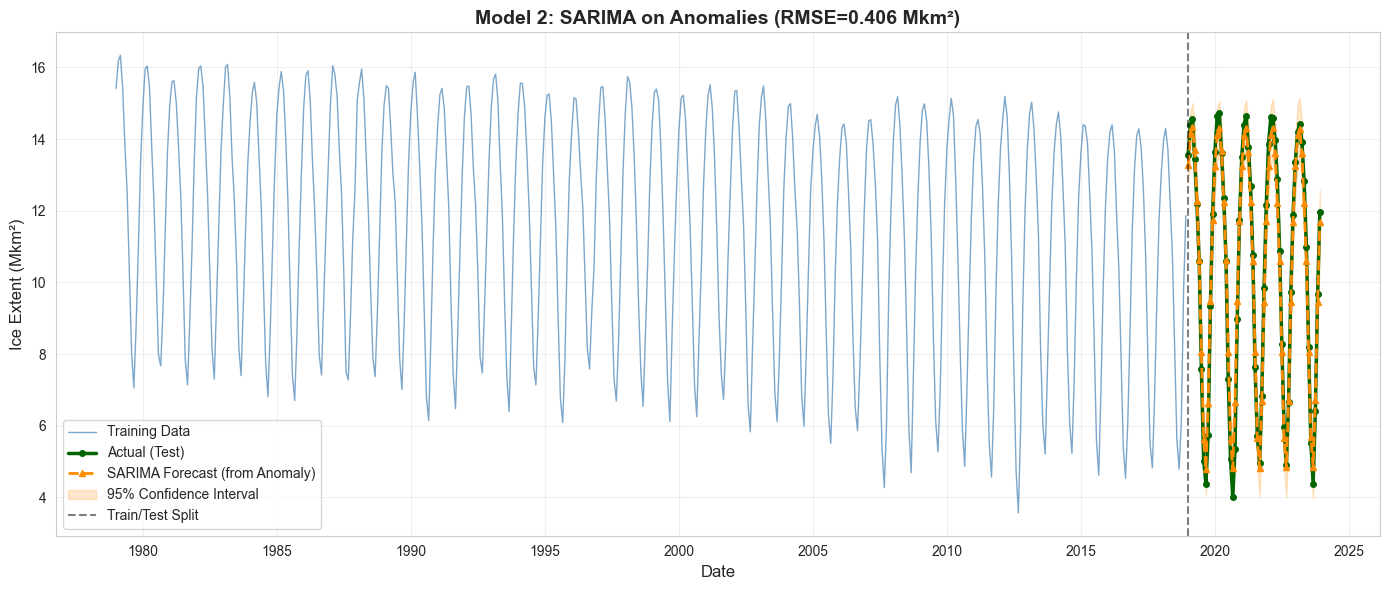

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index.to_timestamp(), train_extent_raw, 
        label='Training Data', color='steelblue', alpha=0.7, linewidth=1)

ax.plot(test_data.index.to_timestamp(), test_extent_raw, 
        label='Actual (Test)', color='darkgreen', linewidth=2.5, marker='o', markersize=4)

ax.plot(test_data.index.to_timestamp(), forecast_anomaly_to_raw, 
        label='SARIMA Forecast (from Anomaly)', color='darkorange', linewidth=2, linestyle='--', marker='^', markersize=4)

ax.fill_between(
    test_data.index.to_timestamp(), 
    forecast_anomaly_ci_raw_lower, 
    forecast_anomaly_ci_raw_upper, 
    alpha=0.2, color='darkorange', label='95% Confidence Interval'
)

ax.axvline(pd.Period(train_test_split_date).to_timestamp(), 
           color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Train/Test Split')

ax.set_title(f'Model 2: SARIMA on Anomalies (RMSE={rmse_model2:.3f} Mkm²)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ice Extent (Mkm²)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

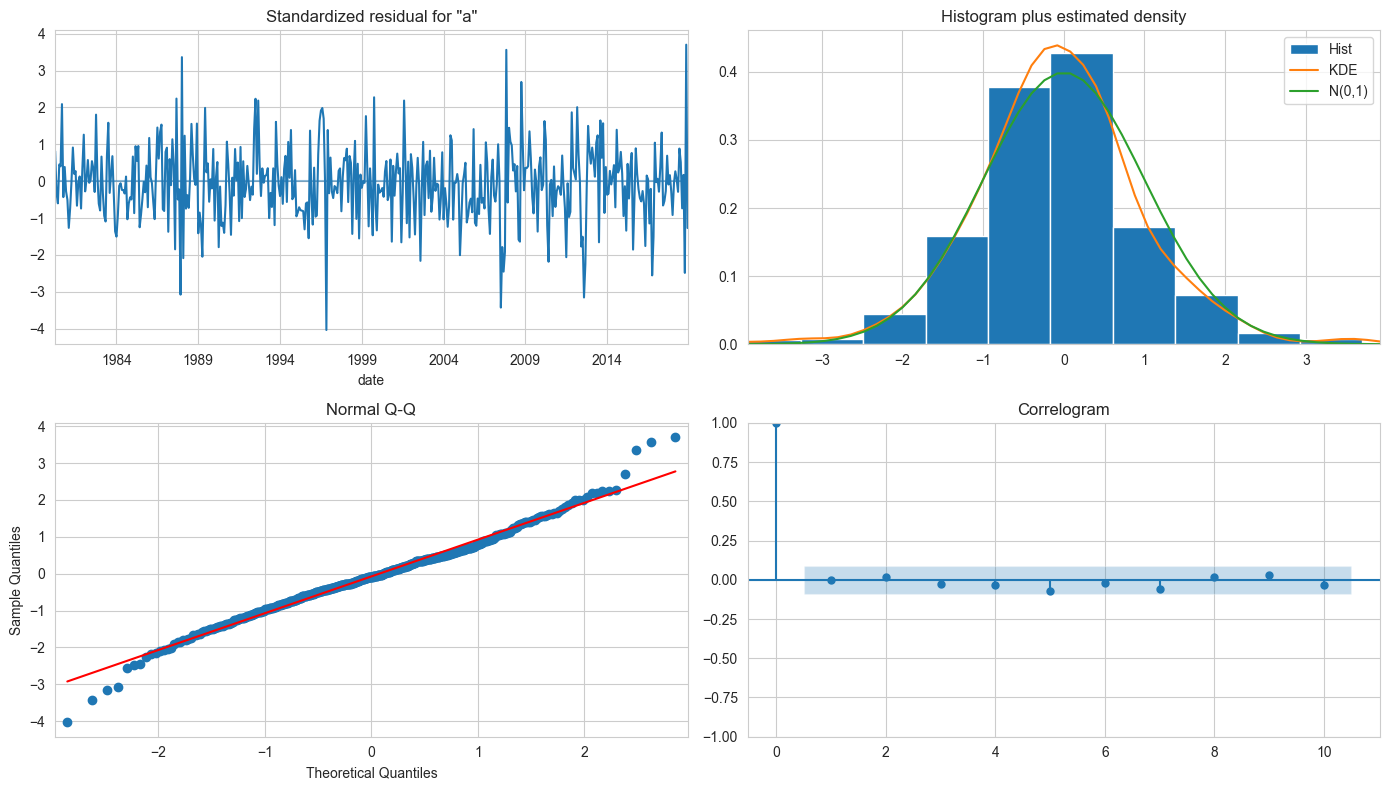

In [25]:
sarima_results_anomaly.plot_diagnostics(figsize=(14, 8))
plt.tight_layout()
plt.show()

## Model Comparison & Conclusions

Direct comparison of both SARIMA approaches on the same test set.

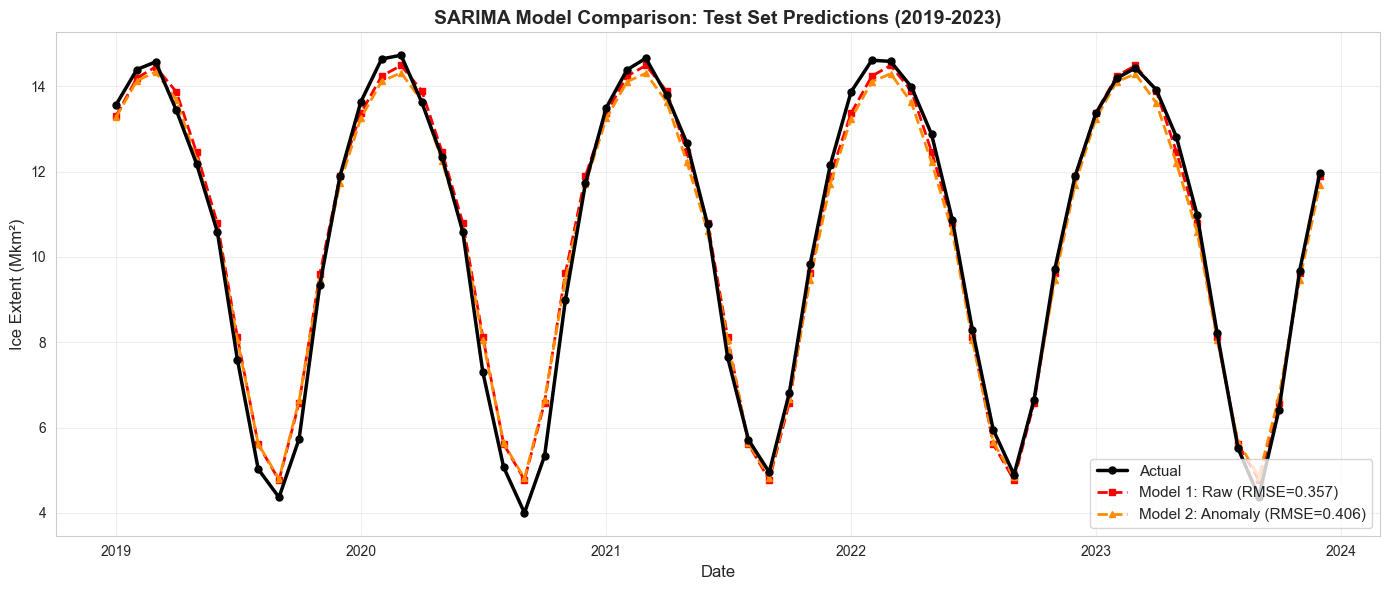

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(test_data.index.to_timestamp(), test_extent_raw, 
        label='Actual', color='black', linewidth=2.5, marker='o', markersize=5, zorder=3)

ax.plot(test_data.index.to_timestamp(), forecast_raw_series, 
        label=f'Model 1: Raw (RMSE={rmse_model1:.3f})', 
        color='red', linewidth=2, linestyle='--', marker='s', markersize=4)

ax.plot(test_data.index.to_timestamp(), forecast_anomaly_to_raw, 
        label=f'Model 2: Anomaly (RMSE={rmse_model2:.3f})', 
        color='darkorange', linewidth=2, linestyle='--', marker='^', markersize=4)

ax.set_title('SARIMA Model Comparison: Test Set Predictions (2019-2023)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ice Extent (Mkm²)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()